<a href="https://colab.research.google.com/github/YDj-robot/Air-Quality-Archive-Nakuru-City-in-Kenya/blob/main/Air_Quality_Nakuru_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Air Quality Archive Nakuru City in Kenya
This data set contains PM (particulate matter), temperature, and humidity readings taken with low-cost sensors. These sensors measure the concentration of PM in the air, including particles with diameters less than or equal to 1 micrometer (PM1), 2.5 micrometers (PM2.5), and particles with diameters less than or equal to 10 micrometers (PM10). The data set includes information on the sensor type, date, time, and location of the readings, as well as the sensor’s specific measurement values for Temperature (C), Humidity (%), PM1, PM2.5, and PM10. The data set is ideal for researchers and individuals interested in studying air quality and low-cost sensors in PM measurement. The dataset is stored in CSV format and can be opened using editors like Microsoft Excel, Google Sheets, LibreOffice Calc, etc. Note that P0 in the data represents PM1, P2 represents PM2.5, and P1 represents PM10.

August 2021 Sensor Data Archive
https://openafrica.net/dataset/678d3d27-1973-4c50-b1c0-5df331fd6d4e/resource/210c1d47-7c77-4bc9-a89b-51c0abb285dc/download/august_2021_sensor_data_archive.csv

###1-Import Data

In [2]:
import pytz
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file_path = "/content/august_2021_sensor_data_archive.csv"
df_all = pd.read_csv(file_path, delimiter=';')
df_all.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,humidity,55
1,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,temperature,22
2,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P2,4
3,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P1,5
4,144,SDS011,3528,-0.286,36.067,2021-08-03T07:22:58.571931+00:00,P2,4


In [4]:
def wrangle(df):

    # Get the P2 values data
    df = df[df['value_type'] == 'P2']

    # Select only the timestamp and P2 values
    df = df[['timestamp', 'value']]
    df.rename(columns={'value': 'P2'}, inplace=True)
    df.set_index('timestamp', inplace=True)

    # Localize timezone
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_convert("Africa/Nairobi")

    # Resample to 1H window
    y = df["P2"].resample("1H").mean()

    return y

In [5]:
y_P2 = wrangle(df_all)
y_P2.head()

timestamp
2021-08-03 10:00:00+03:00    4.500000
2021-08-03 11:00:00+03:00    4.454545
2021-08-03 12:00:00+03:00    5.000000
2021-08-03 13:00:00+03:00    4.454545
2021-08-03 14:00:00+03:00    5.304348
Freq: H, Name: P2, dtype: float64

###2-Explore: Create ACF and PACF plots

In [6]:
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

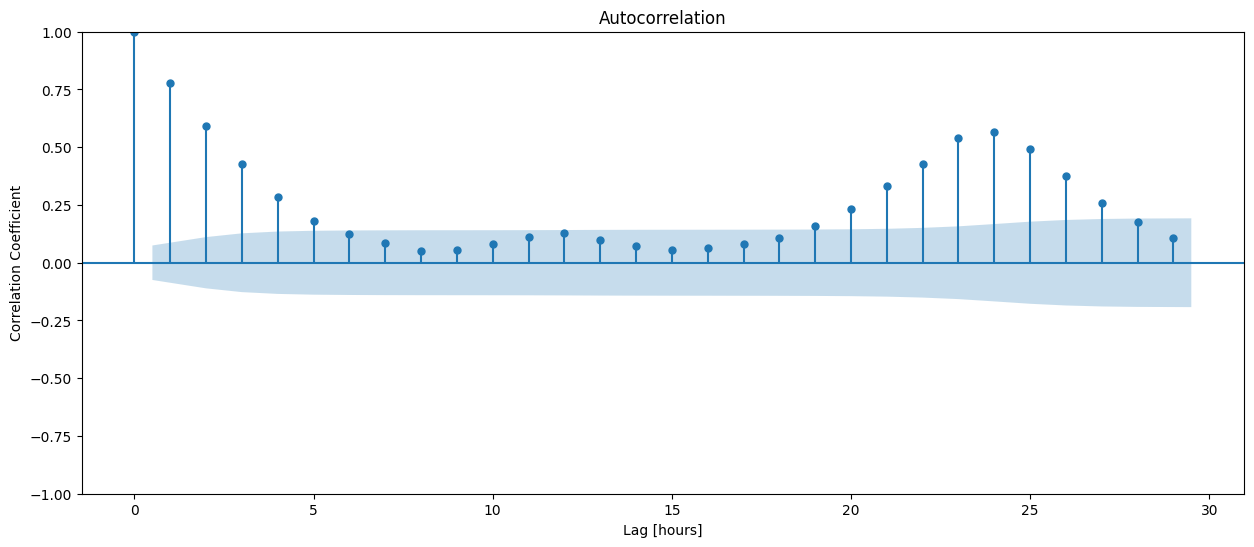

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_P2, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

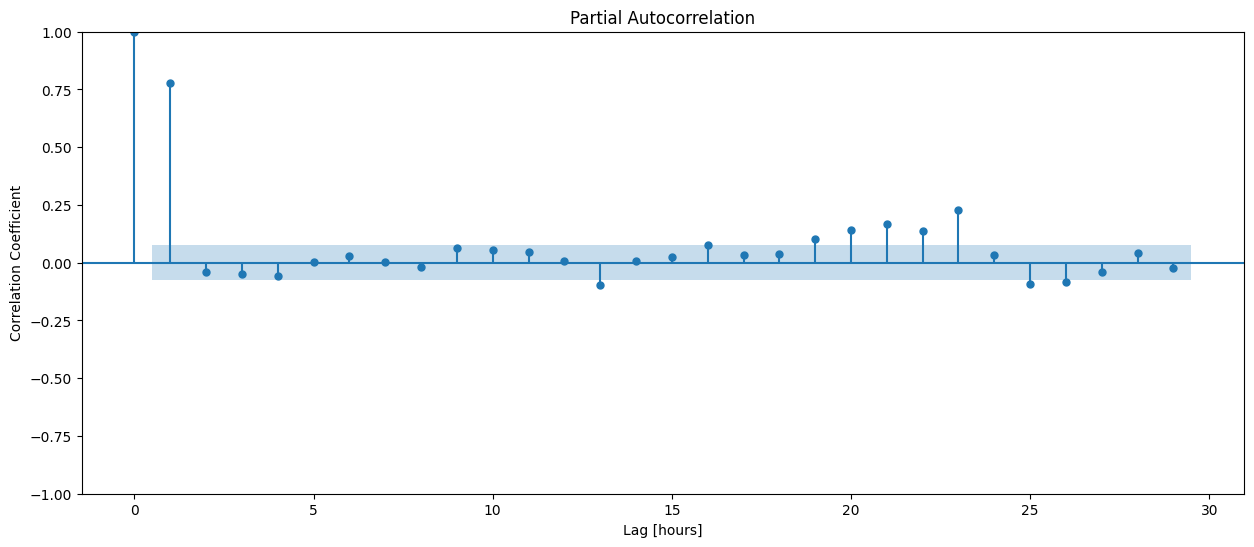

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y_P2, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

###3-Split Train-Test Data

In [26]:
# 80% train data, 20% test data
cutoff = int(len(y_P2) * 0.8)

y_train = y_P2.iloc[:cutoff]
y_test = y_P2.iloc[cutoff:]

## Building Autoregressive (AR) Model

###1-Baseline

In [27]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.51
Baseline MAE: 4.99


###2-Build the AR model

In [35]:
model = AutoReg(y_train, lags=24).fit()

In [36]:
#  calculate train mean absolute error
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[24:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.401323356939307


<Axes: xlabel='timestamp', ylabel='Residual Value'>

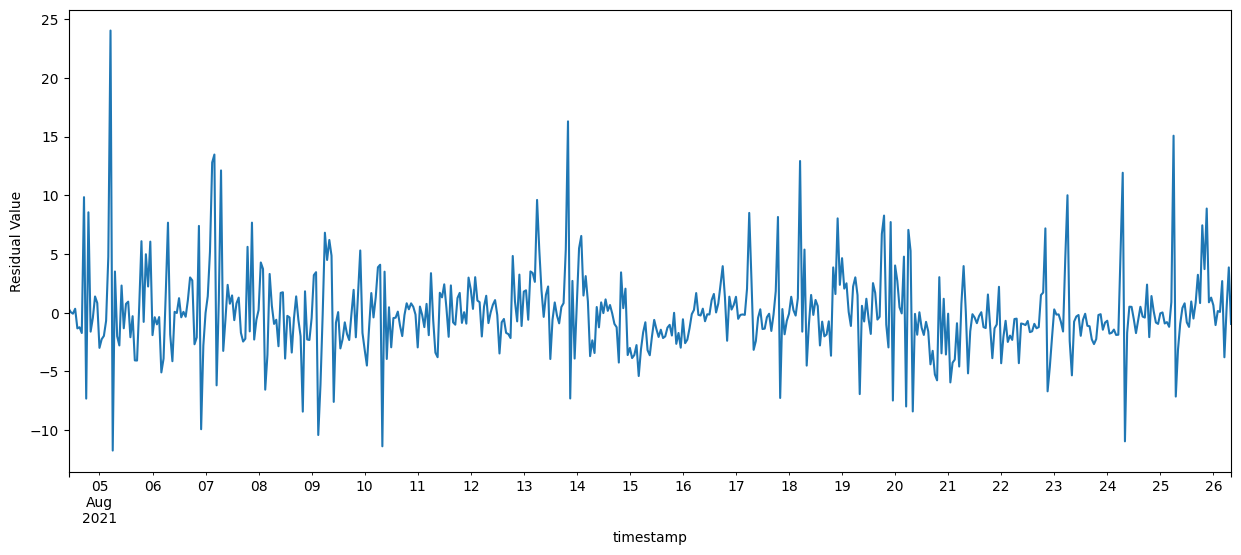

In [37]:
# calculate the residuals for the model and plot them.
y_train_resid = model.resid
# Time series plot
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax)

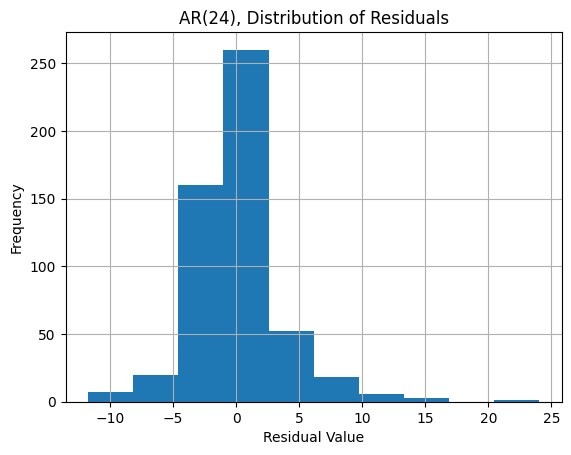

In [38]:
# Histogram plot
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(24), Distribution of Residuals");

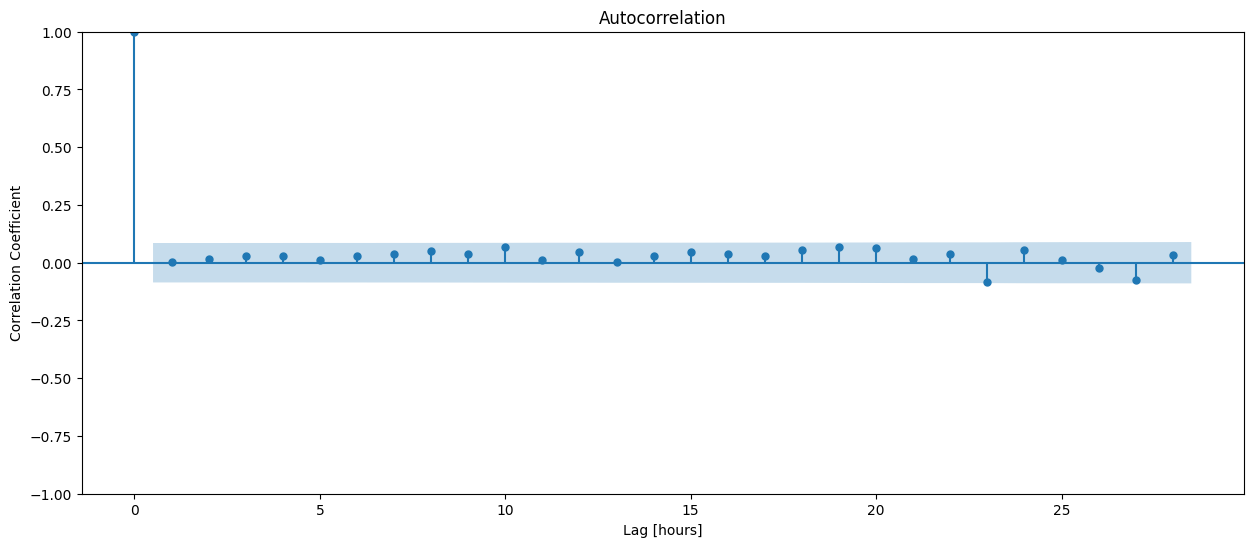

In [39]:
#  ACF plot of `y_train_resid`
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

###3-Evaluate

In [40]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 4.451264749813115


In [41]:
print("Is Training MAE less than the Baseline MAE:", training_mae < mae_baseline)
print("Is Test MAE less than the Baseline MAE:", test_mae < mae_baseline)

Is Training MAE less than the Baseline MAE: True
Is Test MAE less than the Baseline MAE: True


In [43]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test,
     "y_pred": y_pred_test}, index=y_test.index
)

In [44]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

***Why is my model performing poorly?***
because it is using 24 lag data to predict the new value and at some point, the model is using a predicted values to get (calculate) a new predict value.
***What is the solution?***
walk-forward validation

In [48]:
# Perform walk-forward validation for your model for the entire test set y_test
%%capture
y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):

    r = AutoReg(history, 24, old_names=False).fit()
    next_pred = r.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [49]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.57


##Communicate Results

In [50]:
print(model.params)

const     0.670850
P2.L1     0.663982
P2.L2     0.003977
P2.L3    -0.008122
P2.L4    -0.047569
P2.L5    -0.042138
P2.L6     0.050562
P2.L7     0.022450
P2.L8    -0.069581
P2.L9     0.023707
P2.L10    0.018222
P2.L11   -0.031580
P2.L12    0.121938
P2.L13   -0.100619
P2.L14    0.006486
P2.L15   -0.016771
P2.L16    0.024128
P2.L17    0.010278
P2.L18   -0.034183
P2.L19    0.027698
P2.L20    0.014068
P2.L21    0.040458
P2.L22   -0.023873
P2.L23    0.244123
P2.L24    0.036166
dtype: float64


In [51]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}, index=y_test.index
)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.show()